## Jupyter Notebook: Bab 7 - Ensemble Learning and Random Forests

### Pendahuluan
Bab ini akan membahas konsep *Ensemble Learning* dan *Random Forests*, yang merupakan metode Machine Learning yang menggabungkan prediksi dari beberapa model individu untuk mencapai performa yang lebih baik. Kita akan mereproduksi kode dan menjelaskan teori di baliknya, merujuk pada buku "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow" edisi kedua oleh Aurélien Géron.

### Setup Awal
Pastikan Anda telah menginstal semua library yang diperlukan:

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingRegressor, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.svm import SVC
import joblib # Untuk menyimpan model

# Untuk memastikan output yang konsisten
np.random.seed(42)

# Membuat dataset contoh (moons dataset) untuk klasifikasi
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Fungsi untuk plot decision boundaries (akan digunakan di beberapa bagian)
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contourf=None):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    plt.contourf(x1, x2, y_pred, alpha=alpha, cmap=plt.cm.RdBu, zorder=0)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu, edgecolor='k', s=20, zorder=10)
    plt.axis(axes)
    plt.xlabel("Fitur 1")
    plt.ylabel("Fitur 2")

## 1. Voting Classifiers

### Teori
*Voting Classifier* adalah salah satu metode *Ensemble Learning* yang paling sederhana. Metode ini bekerja dengan melatih beberapa klasifikasi yang berbeda (atau jenis yang sama tetapi dengan *hyperparameter* yang berbeda) dan kemudian menggabungkan prediksi mereka. Ide dasarnya adalah bahwa sekelompok "ahli" yang beragam seringkali lebih baik daripada ahli tunggal terbaik.

Ada dua jenis utama *Voting Classifier*:
1.  **Hard Voting (Majority Voting)**: Klasifikasi memilih kelas yang paling sering diprediksi oleh masing-masing klasifikasi individu. Ini seperti mengambil "suara terbanyak".
2.  **Soft Voting**: Jika semua klasifikasi individu mampu memprediksi probabilitas kelas (misalnya, memiliki metode `predict_proba()`), maka *soft voting* akan menghitung probabilitas kelas rata-rata di semua klasifikasi individu dan memilih kelas dengan probabilitas rata-rata tertinggi. *Soft voting* seringkali memberikan performa yang lebih tinggi karena memberikan bobot lebih pada suara dengan keyakinan tinggi.

*Ensemble Learning* bekerja paling baik ketika prediksi individu memiliki tingkat independensi setinggi mungkin (yaitu, mereka membuat kesalahan yang tidak berkorelasi). Salah satu cara untuk mendapatkan klasifikasi yang beragam adalah melatih mereka menggunakan algoritma yang sangat berbeda.

Akurasi Hard Voting:
LogisticRegression: 0.8640
RandomForestClassifier: 0.8960
SVC: 0.8960
VotingClassifier: 0.9120

Akurasi Soft Voting:
LogisticRegression: 0.8640
RandomForestClassifier: 0.8960
SVC: 0.8960
VotingClassifier: 0.9200


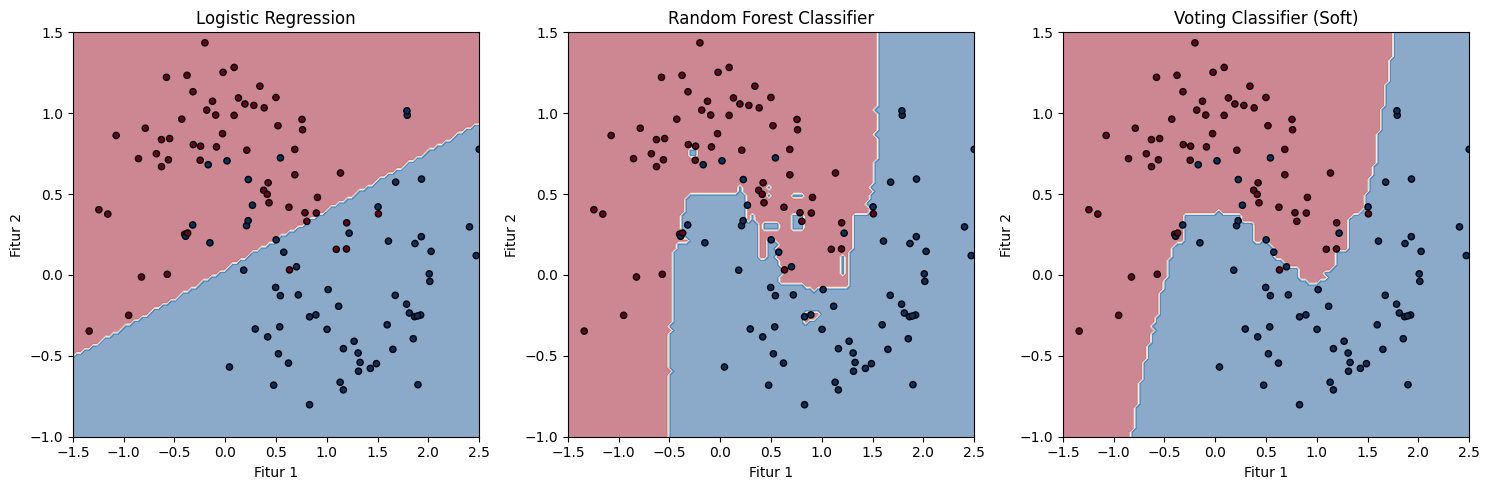

In [13]:
# Inisialisasi klasifikasi individu
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42) # Menggunakan gamma="scale" karena default akan berubah

# Membuat VotingClassifier dengan hard voting
voting_clf_hard = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard'
)
voting_clf_hard.fit(X_train, y_train)

# Mengevaluasi akurasi setiap klasifikasi individu dan voting classifier (hard)
print("Akurasi Hard Voting:")
for clf in (log_clf, rnd_clf, svm_clf, voting_clf_hard):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f"{clf.__class__.__name__}: {accuracy_score(y_test, y_pred):.4f}")

# Membuat VotingClassifier dengan soft voting (membutuhkan predict_proba)
# SVC perlu diatur probability=True agar bisa memprediksi probabilitas
svm_clf_soft = SVC(gamma="scale", probability=True, random_state=42)
voting_clf_soft = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf_soft)],
    voting='soft'
)
voting_clf_soft.fit(X_train, y_train)

# Mengevaluasi akurasi setiap klasifikasi individu dan voting classifier (soft)
print("\nAkurasi Soft Voting:")
for clf in (log_clf, rnd_clf, svm_clf_soft, voting_clf_soft):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f"{clf.__class__.__name__}: {accuracy_score(y_test, y_pred):.4f}")

# Visualisasi Decision Boundary untuk perbandingan
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plot_decision_boundary(log_clf, X_test, y_test)
plt.title("Logistic Regression")
plt.subplot(1, 3, 2)
plot_decision_boundary(rnd_clf, X_test, y_test)
plt.title("Random Forest Classifier")
plt.subplot(1, 3, 3)
plot_decision_boundary(voting_clf_soft, X_test, y_test)
plt.title("Voting Classifier (Soft)")
plt.tight_layout()
plt.show()

**Analisis Hasil**: Anda akan melihat bahwa `VotingClassifier` (terutama dengan *soft voting*) seringkali memiliki akurasi yang sedikit lebih tinggi daripada klasifikasi individu terbaik. Ini menunjukkan kekuatan dari *ensemble methods*.

## 2. Bagging and Pasting

### Teori
*Bagging* (Bootstrap Aggregating) dan *Pasting* adalah metode *Ensemble Learning* di mana beberapa prediktor dilatih pada subset acak yang berbeda dari dataset pelatihan.
* **Bagging**: Pengambilan sampel dilakukan dengan penggantian (*with replacement*). Ini berarti sebuah instansi data yang sama dapat diambil beberapa kali untuk satu prediktor, dan juga dapat diambil oleh beberapa prediktor berbeda.
* **Pasting**: Pengambilan sampel dilakukan tanpa penggantian (*without replacement*). Sebuah instansi data yang sudah diambil tidak dapat diambil lagi untuk prediktor yang sama.

Setelah semua prediktor dilatih, *ensemble* membuat prediksi untuk instansi baru dengan cukup menggabungkan prediksi dari semua prediktor. Fungsi agregasi biasanya adalah mode statistik (prediksi yang paling sering muncul) untuk klasifikasi, atau rata-rata untuk regresi.

Meskipun setiap prediktor individu mungkin memiliki bias yang lebih tinggi jika dilatih pada dataset asli, agregasi mengurangi bias dan varian. Secara umum, *bagging* cenderung menghasilkan model yang lebih baik karena memperkenalkan lebih banyak keberagaman dalam subset data, yang pada gilirannya mengurangi varian *ensemble*.

**Keuntungan**: Karena setiap prediktor dapat dilatih secara independen, *bagging* dan *pasting* dapat berjalan secara paralel, baik pada core CPU yang berbeda maupun server yang berbeda, sehingga sangat skalabel.

Akurasi BaggingClassifier: 0.9040
Akurasi DecisionTreeClassifier (tunggal): 0.8560


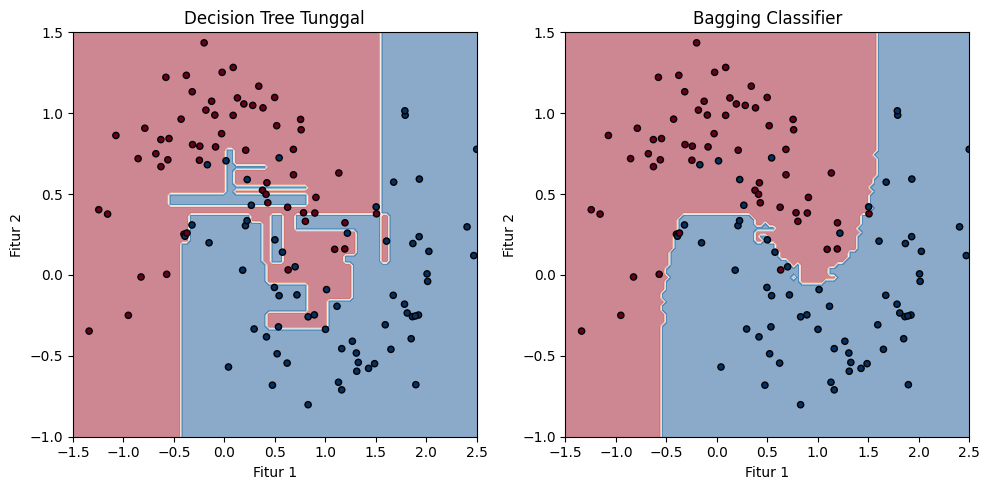

In [14]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# Membuat BaggingClassifier dengan Decision Tree sebagai base estimator
# n_estimators: jumlah Decision Tree yang akan dilatih
# max_samples: jumlah sampel yang diambil untuk setiap Decision Tree
# bootstrap=True: melakukan bagging (pengambilan sampel dengan penggantian)
# n_jobs=-1: menggunakan semua core CPU yang tersedia untuk pelatihan paralel
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1, random_state=42
)
bag_clf.fit(X_train, y_train)

# Mengevaluasi akurasi BaggingClassifier
y_pred_bag = bag_clf.predict(X_test)
print(f"Akurasi BaggingClassifier: {accuracy_score(y_test, y_pred_bag):.4f}")

# Bandingkan dengan Decision Tree tunggal
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(f"Akurasi DecisionTreeClassifier (tunggal): {accuracy_score(y_test, y_pred_tree):.4f}")

# Visualisasi Decision Boundary
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plot_decision_boundary(tree_clf, X_test, y_test)
plt.title("Decision Tree Tunggal")
plt.subplot(1, 2, 2)
plot_decision_boundary(bag_clf, X_test, y_test)
plt.title("Bagging Classifier")
plt.tight_layout()
plt.show()

**Analisis Hasil**: Anda akan melihat bahwa `BaggingClassifier` memiliki *decision boundary* yang lebih halus dan umumnya akurasi yang lebih baik daripada `DecisionTreeClassifier` tunggal. Ini menunjukkan bagaimana *bagging* mengurangi varian dan *overfitting*.

### Evaluasi Out-of-Bag (OOB)

Dalam *bagging*, beberapa instansi data mungkin diambil beberapa kali untuk satu prediktor, sementara yang lain mungkin tidak diambil sama sekali. Sekitar 37% dari instansi pelatihan tidak diambil rata-rata untuk setiap prediktor. Instansi yang tidak diambil ini disebut instansi *out-of-bag* (oob). Karena prediktor tidak pernah melihat instansi OOB selama pelatihan, prediktor dapat dievaluasi pada instansi ini, tanpa memerlukan set validasi terpisah.

In [15]:
# Membuat BaggingClassifier dengan oob_score=True
bag_clf_oob = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1, oob_score=True, random_state=42
)
bag_clf_oob.fit(X_train, y_train)

# Mengakses skor OOB
print(f"Skor OOB BaggingClassifier: {bag_clf_oob.oob_score_:.4f}")

# Bandingkan dengan akurasi pada test set
y_pred_oob = bag_clf_oob.predict(X_test)
print(f"Akurasi BaggingClassifier (pada test set): {accuracy_score(y_test, y_pred_oob):.4f}")

Skor OOB BaggingClassifier: 0.9253
Akurasi BaggingClassifier (pada test set): 0.9040


**Analisis Hasil**: Skor OOB memberikan estimasi kinerja *ensemble* yang cukup akurat tanpa perlu set validasi terpisah. Ini sangat berguna karena memaksimalkan penggunaan data pelatihan.

### Random Patches dan Random Subspaces

`BaggingClassifier` juga mendukung pengambilan sampel fitur. Ini dikontrol oleh *hyperparameter* `max_features` dan `bootstrap_features`.
* **Random Patches**: Pengambilan sampel instansi pelatihan dan fitur dilakukan secara bersamaan.
* **Random Subspaces**: Semua instansi pelatihan digunakan (dengan `bootstrap=False` dan `max_samples=1.0`), tetapi fitur diambil sampelnya (dengan `bootstrap_features=True` dan/atau `max_features` kurang dari 1.0).

Pengambilan sampel fitur menghasilkan keberagaman prediktor yang lebih besar, mengorbankan sedikit bias untuk varian yang lebih rendah.

In [16]:
# Contoh Random Patches (mengambil sampel instansi dan fitur)
# max_features: proporsi fitur yang diambil sampelnya
bag_clf_patches = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, max_features=0.7, bootstrap_features=True,
    n_jobs=-1, random_state=42
)
bag_clf_patches.fit(X_train, y_train)
y_pred_patches = bag_clf_patches.predict(X_test)
print(f"Akurasi BaggingClassifier (Random Patches): {accuracy_score(y_test, y_pred_patches):.4f}")

# Contoh Random Subspaces (mengambil sampel fitur saja)
bag_clf_subspaces = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=1.0, bootstrap=False, max_features=0.7, bootstrap_features=True,
    n_jobs=-1, random_state=42
)
bag_clf_subspaces.fit(X_train, y_train)
y_pred_subspaces = bag_clf_subspaces.predict(X_test)
print(f"Akurasi BaggingClassifier (Random Subspaces): {accuracy_score(y_test, y_pred_subspaces):.4f}")

Akurasi BaggingClassifier (Random Patches): 0.8720
Akurasi BaggingClassifier (Random Subspaces): 0.6480


**Analisis Hasil**: Anda dapat bereksperimen dengan *hyperparameter* ini dan melihat bagaimana pengaruhnya terhadap kinerja model.

## 3. Random Forests

### Teori
*Random Forest* adalah *ensemble* dari *Decision Tree*, umumnya dilatih menggunakan metode *bagging* (atau kadang-kadang *pasting*), biasanya dengan `max_samples` diatur ke ukuran dataset pelatihan. Alih-alih membuat `BaggingClassifier` dan memberikannya `DecisionTreeClassifier`, kita bisa langsung menggunakan kelas `RandomForestClassifier`, yang lebih nyaman dan dioptimalkan untuk *Decision Tree*.

Algoritma *Random Forest* memperkenalkan keacakan ekstra saat menumbuhkan *tree*. Alih-alih mencari fitur terbaik saat membagi *node*, ia mencari fitur terbaik di antara subset fitur acak. Keacakan ekstra ini menghasilkan keberagaman *tree* yang lebih besar, yang (lagi-lagi) mengorbankan bias yang lebih tinggi untuk varian yang lebih rendah, umumnya menghasilkan model yang secara keseluruhan lebih baik.

Akurasi RandomForestClassifier: 0.9120


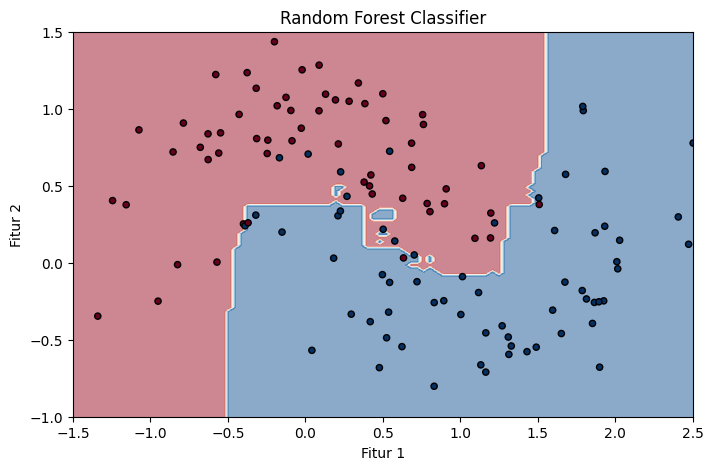

In [17]:
from sklearn.ensemble import RandomForestClassifier

# Membuat RandomForestClassifier
# n_estimators: jumlah tree dalam forest
# max_leaf_nodes: membatasi jumlah node daun untuk setiap tree (regularisasi)
# n_jobs=-1: menggunakan semua core CPU yang tersedia
rnd_clf_rf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf_rf.fit(X_train, y_train)

# Mengevaluasi akurasi RandomForestClassifier
y_pred_rf = rnd_clf_rf.predict(X_test)
print(f"Akurasi RandomForestClassifier: {accuracy_score(y_test, y_pred_rf):.4f}")

# Visualisasi Decision Boundary
plt.figure(figsize=(8, 5))
plot_decision_boundary(rnd_clf_rf, X_test, y_test)
plt.title("Random Forest Classifier")
plt.show()

**Analisis Hasil**: Anda akan melihat bahwa `RandomForestClassifier` memberikan performa yang sangat baik dengan *decision boundary* yang kompleks namun halus.

## 4. Extra-Trees

### Teori
Ketika menumbuhkan *tree* dalam *Random Forest*, hanya subset acak dari fitur yang dipertimbangkan untuk pemisahan pada setiap *node*. *Extra-Trees* mengambil satu langkah lebih jauh dengan juga menggunakan ambang acak untuk setiap fitur, daripada mencari ambang terbaik yang mungkin (seperti yang dilakukan *Decision Tree* biasa).

*Forest* dari *tree* yang sangat acak ini disebut *Extremely Randomized Trees ensemble* (atau disingkat *Extra-Trees*). Teknik ini mengorbankan lebih banyak bias untuk varian yang lebih rendah. Ini juga membuat *Extra-Trees* jauh lebih cepat untuk dilatih daripada *Random Forest* biasa, karena menemukan ambang terbaik yang mungkin untuk setiap fitur di setiap *node* adalah salah satu tugas yang paling memakan waktu dalam menumbuhkan *tree*.

Akurasi ExtraTreesClassifier: 0.9120


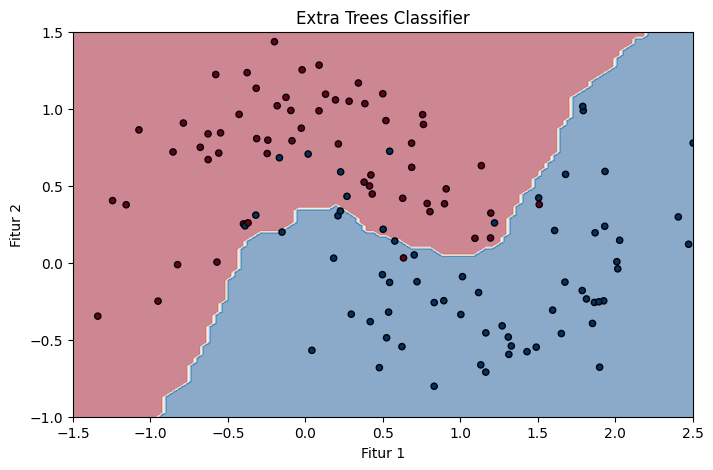

In [18]:
from sklearn.ensemble import ExtraTreesClassifier

# Membuat ExtraTreesClassifier
# API-nya mirip dengan RandomForestClassifier
extra_tree_clf = ExtraTreesClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
extra_tree_clf.fit(X_train, y_train)

# Mengevaluasi akurasi ExtraTreesClassifier
y_pred_et = extra_tree_clf.predict(X_test)
print(f"Akurasi ExtraTreesClassifier: {accuracy_score(y_test, y_pred_et):.4f}")

# Visualisasi Decision Boundary
plt.figure(figsize=(8, 5))
plot_decision_boundary(extra_tree_clf, X_test, y_test)
plt.title("Extra Trees Classifier")
plt.show()

**Analisis Hasil**: Bandingkan akurasi *Extra-Trees* dengan *Random Forest*. Kadang-kadang *Extra-Trees* bisa sedikit lebih baik atau lebih buruk, tetapi seringkali lebih cepat dilatih.

## 5. Feature Importance

### Teori
Salah satu kualitas hebat dari *Random Forest* adalah mereka memudahkan untuk mengukur kepentingan relatif dari setiap fitur. Scikit-Learn mengukur kepentingan fitur dengan melihat seberapa banyak *node tree* yang menggunakan fitur tersebut mengurangi *impurity* rata-rata (di semua *tree* dalam *forest*). Secara lebih tepat, ini adalah rata-rata tertimbang, di mana bobot setiap *node* sama dengan jumlah sampel pelatihan yang terkait dengannya.

Scikit-Learn menghitung skor ini secara otomatis untuk setiap fitur setelah pelatihan, kemudian menskalakan hasilnya sehingga jumlah semua kepentingan sama dengan 1. Anda dapat mengakses hasilnya menggunakan variabel `feature_importances_`.


Kepentingan Fitur pada Dataset Iris:
sepal length (cm): 0.1125
sepal width (cm): 0.0231
petal length (cm): 0.4410
petal width (cm): 0.4234


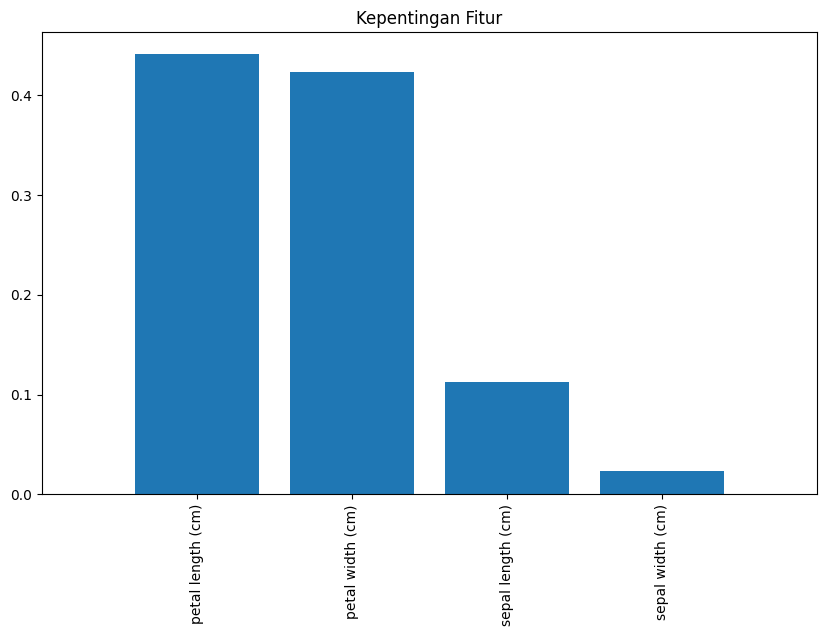

In [19]:
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier

# Muat dataset Iris
iris = load_iris()
X_iris = iris.data
y_iris = iris.target

# Latih RandomForestClassifier
rnd_clf_iris = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
rnd_clf_iris.fit(X_iris, y_iris)

# Tampilkan kepentingan fitur
print("\nKepentingan Fitur pada Dataset Iris:")
for name, score in zip(iris["feature_names"], rnd_clf_iris.feature_importances_):
    print(f"{name}: {score:.4f}")

# Visualisasi (opsional: jika Anda ingin melihat kepentingan fitur dalam bentuk bar chart)
features = iris["feature_names"]
importances = rnd_clf_iris.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Kepentingan Fitur")
plt.bar(range(X_iris.shape[1]), importances[indices], align="center")
plt.xticks(range(X_iris.shape[1]), [features[i] for i in indices], rotation=90)
plt.xlim([-1, X_iris.shape[1]])
plt.show()

**Analisis Hasil**: Anda akan melihat bahwa panjang dan lebar kelopak (petal length dan petal width) adalah fitur yang paling penting untuk klasifikasi bunga Iris, yang sesuai dengan intuisi dari eksplorasi data pada Bab 4.

## 6. Boosting

### Teori
*Boosting* (awalnya disebut *hypothesis boosting*) mengacu pada metode *Ensemble* apa pun yang dapat menggabungkan beberapa *weak learner* menjadi *strong learner*. Ide umum dari sebagian besar metode *boosting* adalah melatih prediktor secara berurutan, di mana setiap prediktor mencoba mengoreksi pendahulunya.

Dua metode *boosting* yang paling populer adalah *AdaBoost* (Adaptive Boosting) dan *Gradient Boosting*.

### AdaBoost (Adaptive Boosting)

*AdaBoost* bekerja dengan memberikan perhatian lebih pada instansi pelatihan yang salah diklasifikasikan oleh prediktor sebelumnya. Ini menghasilkan prediktor baru yang semakin fokus pada kasus-kasus yang sulit.

Algoritma *AdaBoost*:
1.  Setiap bobot instansi $w^{(i)}$ awalnya diatur ke $1/m$.
2.  Prediktor pertama dilatih, dan *weighted error rate* $r_1$ dihitung pada set pelatihan.
3.  Bobot prediktor $\alpha_j$ dihitung (semakin akurat prediktor, semakin tinggi bobotnya).
4.  Bobot instansi diperbarui, dengan bobot instansi yang salah diklasifikasikan ditingkatkan.
5.  Prediktor baru dilatih menggunakan bobot yang diperbarui, dan proses ini diulang.

Prediksi *ensemble* *AdaBoost* didasarkan pada mayoritas suara tertimbang dari semua prediktor.

/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


Akurasi AdaBoostClassifier: 0.8960


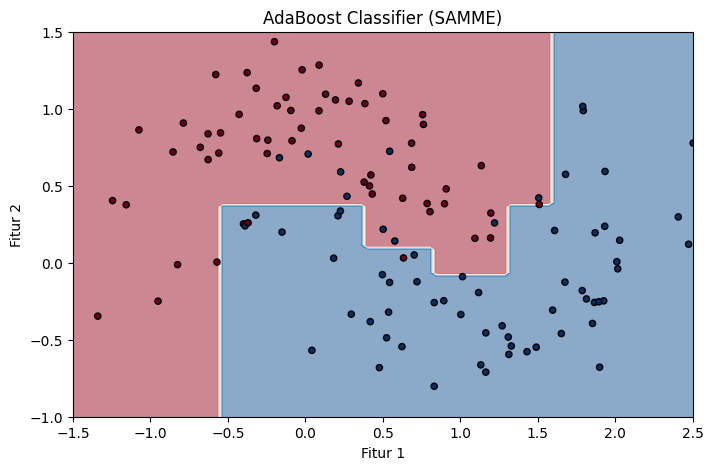

In [20]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np # Pastikan numpy diimpor

# Asumsi X_train, y_train, X_test, y_test sudah didefinisikan dari setup awal
# Asumsi fungsi plot_decision_boundary juga sudah didefinisikan

# Membuat AdaBoostClassifier dengan Decision Tree Stump (max_depth=1) sebagai base estimator
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1, random_state=42), n_estimators=200,
    algorithm="SAMME", # Diubah menjadi "SAMME"
    learning_rate=0.5, random_state=42
)
ada_clf.fit(X_train, y_train)

# Mengevaluasi akurasi AdaBoostClassifier
y_pred_ada = ada_clf.predict(X_test)
print(f"Akurasi AdaBoostClassifier: {accuracy_score(y_test, y_pred_ada):.4f}")

# Visualisasi Decision Boundary
plt.figure(figsize=(8, 5))
plot_decision_boundary(ada_clf, X_test, y_test)
plt.title("AdaBoost Classifier (SAMME)")
plt.show()

**Analisis Hasil**: *AdaBoost* juga membentuk *decision boundary* yang kompleks, seringkali meningkatkan akurasi dibandingkan *base estimator* tunggal.

### Gradient Boosting

*Gradient Boosting* juga bekerja dengan menambahkan prediktor secara berurutan ke dalam *ensemble*, di mana setiap prediktor mengoreksi pendahulunya. Namun, alih-alih mengubah bobot instansi seperti *AdaBoost*, metode ini mencoba menyesuaikan prediktor baru dengan *residual errors* yang dibuat oleh prediktor sebelumnya.

Untuk regresi, setiap *tree* dilatih pada *residual errors* dari *tree* sebelumnya. Prediksi akhir adalah jumlah prediksi dari semua *tree*.


MSE GradientBoostingRegressor: 0.8415


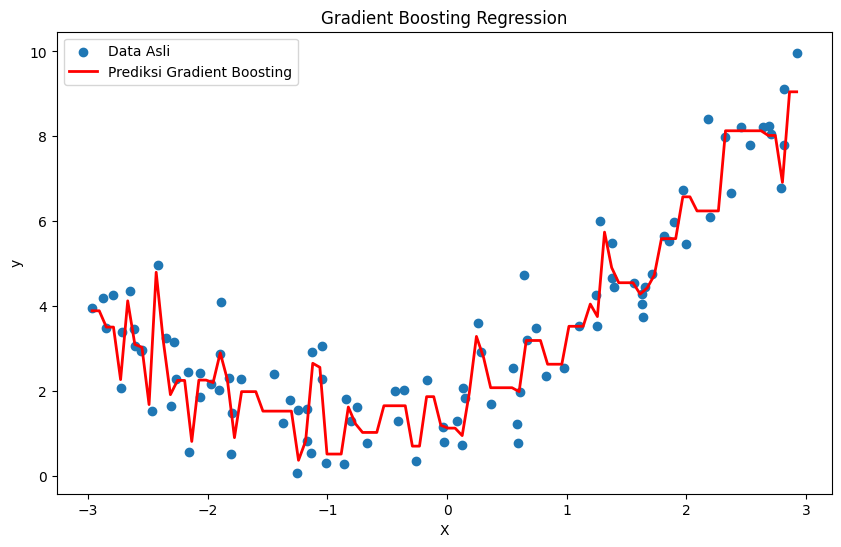

In [21]:
from sklearn.ensemble import GradientBoostingRegressor

# Membuat dataset untuk regresi (contoh sederhana)
np.random.seed(42)
X_reg = np.random.rand(100, 1) * 6 - 3
y_reg = 0.5 * X_reg**2 + X_reg + 2 + np.random.randn(100, 1)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, random_state=42)

# Melatih GradientBoostingRegressor
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=300, learning_rate=0.1, random_state=42)
gbrt.fit(X_train_reg, y_train_reg.ravel()) # .ravel() karena y_reg adalah 2D

# Mengevaluasi MSE
y_pred_gbrt = gbrt.predict(X_test_reg)
print(f"\nMSE GradientBoostingRegressor: {mean_squared_error(y_test_reg, y_pred_gbrt):.4f}")

# Visualisasi hasil regresi
X_new_reg = np.linspace(X_reg.min(), X_reg.max(), 100).reshape(-1, 1)
y_pred_gbrt_plot = gbrt.predict(X_new_reg)

plt.figure(figsize=(10, 6))
plt.scatter(X_reg, y_reg, label="Data Asli")
plt.plot(X_new_reg, y_pred_gbrt_plot, "r-", linewidth=2, label="Prediksi Gradient Boosting")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.title("Gradient Boosting Regression")
plt.show()

**Analisis Hasil**: *Gradient Boosting* dapat menghasilkan model regresi yang sangat baik yang mampu menangani pola non-linear dalam data.

### Early Stopping dalam Gradient Boosting

Untuk menemukan jumlah *tree* yang optimal dalam *Gradient Boosting*, kita dapat menggunakan *early stopping*.

In [23]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np

# Asumsi X_train_reg, y_train_reg, X_test_reg, y_test_reg sudah didefinisikan
# dari setup awal untuk regresi

# Latih GBRT dengan jumlah estimator yang besar dan warm_start=True
gbrt_es = GradientBoostingRegressor(max_depth=2, n_estimators=300, learning_rate=0.1, warm_start=True, random_state=42)

# Membagi data pelatihan menjadi pelatihan dan validasi untuk early stopping
X_train_es, X_val_es, y_train_es, y_val_es = train_test_split(X_train_reg, y_train_reg.ravel(), test_size=0.1, random_state=42)

# Latih model GBRT di sini sebelum memanggil staged_predict
# Untuk warm_start, panggil fit() dengan n_estimators yang bertambah secara bertahap
# atau dengan n_estimators penuh jika ingin langsung mengevaluasi staged_predict
gbrt_es.fit(X_train_es, y_train_es) # <--- TAMBAHKAN BARIS INI

errors = [mean_squared_error(y_val_es, y_pred) for y_pred in gbrt_es.staged_predict(X_val_es)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, learning_rate=0.1, random_state=42)
gbrt_best.fit(X_train_es, y_train_es)

y_pred_gbrt_es = gbrt_best.predict(X_test_reg)
print(f"MSE GradientBoostingRegressor (Early Stopping): {mean_squared_error(y_test_reg, y_pred_gbrt_es):.4f}")
print(f"Jumlah estimator optimal: {bst_n_estimators}")

MSE GradientBoostingRegressor (Early Stopping): 3.1235
Jumlah estimator optimal: 6


**Analisis Hasil**: *Early stopping* membantu mencegah *overfitting* dan menemukan model yang memiliki kinerja terbaik pada data validasi.

## 7. Stacking

### Teori
*Stacking* (Stacked Generalization) adalah metode *Ensemble* di mana alih-alih menggunakan fungsi trivial (seperti *hard voting*) untuk menggabungkan prediksi semua prediktor dalam *ensemble*, kita melatih model untuk melakukan agregasi ini. Model agregasi ini sering disebut *blender* atau *meta learner*.

Proses pelatihan *stacking* melibatkan beberapa tahapan:
1.  **Tahap Pertama**: Dataset pelatihan dibagi menjadi dua subset. Subset pertama digunakan untuk melatih prediktor pada lapisan pertama.
2.  **Tahap Kedua**: Prediktor dari lapisan pertama digunakan untuk membuat prediksi pada subset kedua (yang ditahan). Ini memastikan bahwa prediksi tersebut "bersih" karena prediktor tidak pernah melihat instansi ini selama pelatihan.
3.  **Membuat Dataset Baru**: Dataset pelatihan baru dibuat menggunakan prediksi dari lapisan pertama sebagai fitur masukan, dan nilai target asli sebagai target.
4.  **Melatih Blender**: *Blender* dilatih pada dataset pelatihan baru ini.

Pendekatan ini dapat diperluas ke beberapa lapisan *ensemble*, dengan setiap lapisan melatih *blender* pada prediksi dari lapisan sebelumnya.

In [24]:
# Asumsikan X_train, X_test, y_train, y_test sudah ada dari setup awal (make_moons)

# 1. Melatih klasifikasi lapisan pertama pada subset pertama dari data pelatihan
# Bagi X_train dan y_train menjadi dua subset: X_train_blender_1, X_train_blender_2
# Misalnya, 50% untuk training base models, 50% untuk training blender
X_train_base, X_train_blender, y_train_base, y_train_blender = train_test_split(
    X_train, y_train, test_size=0.5, random_state=42
)

# Inisialisasi dan latih klasifikasi lapisan pertama
clf1 = LogisticRegression(solver="lbfgs", random_state=42)
clf2 = RandomForestClassifier(n_estimators=100, random_state=42)
clf3 = SVC(gamma="scale", probability=True, random_state=42)

clf1.fit(X_train_base, y_train_base)
clf2.fit(X_train_base, y_train_base)
clf3.fit(X_train_base, y_train_base)

# 2. Membuat prediksi pada subset kedua (untuk melatih blender)
X_val_predictions = np.c_[
    clf1.predict_proba(X_train_blender)[:, 1],
    clf2.predict_proba(X_train_blender)[:, 1],
    clf3.predict_proba(X_train_blender)[:, 1],
]

# 3. Melatih blender (meta-learner) pada prediksi ini
blender = LogisticRegression(solver="lbfgs", random_state=42)
blender.fit(X_val_predictions, y_train_blender)

# 4. Membuat prediksi pada test set
# Dapatkan prediksi dari klasifikasi lapisan pertama pada X_test
X_test_predictions = np.c_[
    clf1.predict_proba(X_test)[:, 1],
    clf2.predict_proba(X_test)[:, 1],
    clf3.predict_proba(X_test)[:, 1],
]

# Dapatkan prediksi akhir dari blender
y_pred_stack = blender.predict(X_test_predictions)
print(f"Akurasi Stacking Classifier: {accuracy_score(y_test, y_pred_stack):.4f}")

# Visualisasi Decision Boundary (untuk blender - mungkin tidak selalu terlihat jelas untuk plotting secara langsung)
# Karena blender dilatih pada output probabilitas, visualisasi langsung di ruang fitur asli bisa rumit.
# Namun, Anda bisa memvisualisasikan bagaimana blender memisahkan ruang probabilitas.

Akurasi Stacking Classifier: 0.8960


**Analisis Hasil**: *Stacking* seringkali dapat mencapai akurasi yang lebih tinggi daripada metode *ensemble* lainnya karena *blender* dapat belajar bagaimana cara terbaik menggabungkan prediksi dari model-model dasar.

### Kesimpulan Bab 7

Bab ini telah memberikan pemahaman mendalam tentang *Ensemble Learning* dan *Random Forests*, mencakup berbagai metode seperti *Voting Classifiers*, *Bagging*, *Pasting*, *Random Forests* itu sendiri, *Extra-Trees*, *Boosting* (dengan *AdaBoost* dan *Gradient Boosting*), dan *Stacking*. Melalui teori dan implementasi praktis di Python menggunakan Scikit-Learn, kita telah melihat bagaimana menggabungkan kekuatan prediktor individu dapat secara signifikan meningkatkan kinerja model Machine Learning secara keseluruhan.

Poin-poin penting yang perlu diingat:
* **Keberagaman Model**: *Ensemble methods* bekerja paling baik ketika prediktor-prediktor dasar seberagam mungkin.
* **Bias vs. Varian**: *Bagging* cenderung mengurangi varian, sementara *boosting* cenderung mengurangi bias.
* **Skalabilitas**: *Bagging* dan *Random Forest* sangat skalabel karena dapat dilatih secara paralel.
* **Pentingnya Fitur**: *Random Forest* dapat memberikan wawasan tentang kepentingan fitur, yang berguna untuk interpretasi model dan *feature selection*.

Metode-metode ini sangat ampuh dan sering digunakan dalam kompetisi Machine Learning dan aplikasi dunia nyata untuk mencapai kinerja yang canggih.